> **Environment Setup:**

Set environment variables to disable TensorFlow and Flax in Hugging Face Transformers to avoid compatibility issues.

> **Environment Setup: Disabling TensorFlow and Flax in Transformers**

This cell sets environment variables to prevent Hugging Face Transformers from attempting to use TensorFlow or Flax backends. This is important to avoid compatibility issues, especially with NumPy 2.x and to ensure that only PyTorch is used for model loading and inference.

In [1]:
import os
os.environ['TRANSFORMERS_NO_TF'] = '1'
os.environ['TRANSFORMERS_NO_FLAX'] = '1'
print('TF/Flax disabled for Transformers imports.')

TF/Flax disabled for Transformers imports.


> **Importing Core Libraries for Model Evaluation**

This cell imports essential Python libraries and modules required for the experiments. It includes math for calculations, torch for deep learning operations, time for performance measurement, typing for type hints, and Hugging Face Transformers for model and tokenizer loading.

In [2]:
import math
import torch
import time
from typing import Dict
from transformers import AutoTokenizer, AutoModelForCausalLM

> **Model Selection: Choosing the LLM for Experiments**

This cell defines the model name to be used throughout the notebook. The selected model (TinyLlama-1.1B-Chat-v1.0) is a compact, chat-optimized language model suitable for running on limited hardware and for demonstrating scaling experiments.

In [3]:
# ─── SETTINGS ────────────────────────────────────────────────────────────────
MODEL_NAME = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"

> **Model and Tokenizer Loader: Device and Precision Handling**

This function loads the specified model and tokenizer from Hugging Face, automatically moves the model to GPU (if available) or CPU, and selects the appropriate numerical precision (float16 for CUDA, float32 otherwise). The model is set to evaluation mode to disable training-specific behaviors.

In [4]:
def load_model_and_tokenizer(model_name: str):
    """
    TODO:
      - Load tokenizer & model from `model_name`
      - Move model to GPU if available, choose float16 for CUDA else float32
      - Set model to eval mode
      - Return (tokenizer, model, device)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    dtype  = torch.float16 if device.type == "cuda" else torch.float32

    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=dtype
    )
    model.to(device)
    model.eval()
    return tokenizer, model, device


> **Text Selection: Providing a Sample Passage**

This function returns a sample passage of approximately 100 tokens, typically from Wikipedia or a similar source. The passage is used as the input prompt for all subsequent tokenization and evaluation steps, ensuring consistency across experiments.

In [5]:
def select_text():
    """
    TODO:
      - Pick or paste a ~100-token passage (e.g. a Wiki snippet)
      - Return (text_str)
    """
    return (
        "Artificial intelligence (AI) is intelligence demonstrated by machines, in contrast to the natural "
        "intelligence displayed by humans and animals. Leading AI textbooks define the field as the study "
        "of intelligent agents: any system that perceives its environment and takes actions that maximize "
        "its chance of achieving its goals. Colloquially, the term \"artificial intelligence\" is often "
        "used to describe machines that mimic cognitive functions that humans associate with the human mind, "
        "such as learning and problem-solving."
    )

> **Tokenization with Labels: Preparing Model Inputs**

This function tokenizes the selected text using the model's tokenizer, converts the text into input tensors, and sets up the labels for language modeling. The output is a dictionary of tensors ready for model input, along with the input length in tokens.

In [6]:
def tokenize_with_labels(tokenizer, text: str):
    """
    TODO:
      - Tokenize `text` with return_tensors="pt"
      - Prepare inputs and set labels = input_ids
      - Return (inputs_dict, input_len)
    """
    inputs = tokenizer(text, return_tensors="pt")
    inputs["labels"] = inputs["input_ids"].clone()
    input_len = inputs["input_ids"].size(1)
    return inputs, input_len

> **Peak Memory and Loss Calculation: Measuring Resource Usage**

This function runs a forward pass of the model on the provided inputs, measuring the peak GPU memory usage (if CUDA is available) and the loss value. It ensures accurate memory measurement by resetting and synchronizing CUDA memory stats.

In [7]:
def compute_peak_memory_and_loss(model, inputs, device):
    """
    TODO:
      - Reset peak memory stats if CUDA
      - Run model(**inputs) under torch.no_grad()
      - Sync CUDA if needed
      - Retrieve peak memory via torch.cuda.max_memory_allocated (in MiB)
      - Return (peak_mem_mib, loss_value)
    """
    if device.type == "cuda":
        torch.cuda.reset_peak_memory_stats(device)

    with torch.no_grad():
        outputs = model(
            input_ids=inputs["input_ids"].to(device),
            attention_mask=inputs.get("attention_mask", None).to(device) if inputs.get("attention_mask") is not None else None,
            labels=inputs["labels"].to(device)
        )

    if device.type == "cuda":
        torch.cuda.synchronize()
        peak_bytes = torch.cuda.max_memory_allocated(device)
        peak_mib = peak_bytes / 1024**2
    else:
        peak_mib = float("nan")

    return peak_mib, outputs.loss.item()

> **Perplexity Computation: Interpreting Model Loss**

This function converts the model's loss value into perplexity, a standard metric for evaluating language models. Lower perplexity indicates better model performance on the given text.

In [8]:
def compute_perplexity(loss: float):
    """
    TODO:
      - Compute and return math.exp(loss)
    """
    return math.exp(loss)

> **Forward Pass Timing: Measuring Inference Latency**

This function measures the average time taken for the model to perform a forward pass (inference) on the input data. It includes warmup runs to stabilize performance and reports the mean latency over several timed runs.

In [9]:
def time_forward(model, inputs: Dict[str, torch.Tensor], device, num_warmup: int = 1, num_runs: int = 3):
    """
    TODO:
      1) Move all tensors in `inputs` to `device`.
      2) Warmup (no timing): under torch.no_grad(), run a small number of forward passes
         (num_warmup times) to stabilize kernels/clocks:
             _ = model(**inputs_on_device)
         If CUDA, call torch.cuda.synchronize() after warmup.
      3) Timed runs: create an empty list `latencies = []`.
         For _ in range(num_runs):
           - Record start time with time.perf_counter()
           - Under torch.no_grad(), run a forward pass:
                 _ = model(**inputs_on_device)
           - If CUDA, call torch.cuda.synchronize()
           - Record end time with time.perf_counter()
           - Append (end - start) to `latencies`.
      4) Return the average latency in seconds:
             return sum(latencies) / max(len(latencies), 1)
    """
    # warmup
    with torch.no_grad():
        for _ in range(num_warmup):
            _ = model(**{k: v.to(device) for k, v in inputs.items()})
    # timed
    latencies = []
    with torch.no_grad():
        for _ in range(num_runs):
            t0 = time.perf_counter()
            _ = model(**{k: v.to(device) for k, v in inputs.items()})
            if device.type == 'cuda':
                torch.cuda.synchronize()
            t1 = time.perf_counter()
            latencies.append(t1 - t0)
    return sum(latencies) / max(len(latencies), 1)

> **Context Length Sweep: Scaling Analysis with Input Size**

This function systematically increases the input (context) length and measures how peak memory usage and inference latency scale. It builds longer input texts, runs the model, and visualizes the results, helping to understand the model's resource requirements as context grows.

In [10]:
import matplotlib.pyplot as plt

def sweep_context_length(
    tokenizer,
    model,
    device,
    targets=(64, 256, 1024),
    base_text=None,
    build_text_fn=None,
    warmup=1,
    runs=3,
    plot=True,
):
    """
    TODO:
      1) Determine the model's maximum context length:
         - Read `max_position_embeddings` from `model.config` (fallback to 2048).
         - Filter `targets` to those <= `max_len - 2` (leave room for special tokens).
         - If no valid targets remain, raise a ValueError.

      2) Choose a base paragraph:
         - If `base_text` is None, call `select_text()`; if unavailable, raise with a helpful message.

      3) Build texts of desired token lengths:
         - Implement a builder that repeats `base_text` until the tokenized length >= `target_tokens`.
         - Allow overriding via `build_text_fn(tokenizer, base_text, target_tokens)`.

      4) For each target length:
         - Build the text and tokenize with `tokenize_with_labels(tokenizer, text)` to get `(inputs, input_len)`.
         - Move all tensors in `inputs` to `device`.
         - Compute peak memory (MiB) and loss using `compute_peak_memory_and_loss(model, inputs, device)`.
         - Measure forward (prefill) latency using `time_forward(model, inputs, device, num_warmup=warmup, num_runs=runs)`.
         - Append `input_len`, `peak_mib`, and `latency_s` to running lists.
         - Print a concise summary line for each target.

      5) If `plot` is True, create two matplotlib plots (one per figure):
         - Peak memory (MiB) vs input tokens.
         - Forward latency (s) vs input tokens.
         - Use simple line plots with markers and grid; do not specify custom colors.

      6) Return a results dictionary with:
         - 'lengths': list of actual input token counts
         - 'peak_mib': list of peak memory values (MiB)
         - 'latency_s': list of forward latencies (s)
         - 'max_ctx': the model’s max context length
         - 'targets_used': the filtered list of targets
    """
    # 1) Determine max sequence length the model supports
    max_len = getattr(model.config, "max_position_embeddings", 2048)
    targets = [t for t in targets if t <= max_len - 2]  # leave headroom for specials
    if not targets:
        raise ValueError("No targets fit within the model's context window.")

    # 2) Choose base text
    if base_text is None:
        try:
            base_text = select_text()
        except NameError as e:
            raise ValueError("Provide base_text or define select_text().") from e

    # 3) Default builder: repeat base_text until tokenized length >= target
    def _default_build(tokenizer, base_text, target_tokens):
        pieces = []
        while True:
            pieces.append(base_text)
            toks = tokenizer(" ".join(pieces), return_tensors="pt")
            if toks["input_ids"].size(1) >= target_tokens:
                return " ".join(pieces)

    build = build_text_fn or _default_build

    len_list, mem_list, lat_list = [], [], []
    for T in targets:
        text_T = build(tokenizer, base_text, T)
        inputs_T, input_len_T = tokenize_with_labels(tokenizer, text_T)
        inputs_T = {k: v.to(device) for k, v in inputs_T.items()}
        # Peak memory & loss (loss unused here)
        peak_mib, _ = compute_peak_memory_and_loss(model, inputs_T, device)
        # Forward latency (prefill)
        lat_s = time_forward(model, inputs_T, device, num_warmup=warmup, num_runs=runs)

        len_list.append(input_len_T)
        mem_list.append(peak_mib)
        lat_list.append(lat_s)
        print(f"Tokens={input_len_T:4d} | Peak MiB={peak_mib:8.1f} | fwd latency={lat_s:.3f}s")

    if plot:
        plt.figure()
        plt.plot(len_list, mem_list, marker="o")
        plt.xlabel("input tokens")
        plt.ylabel("peak MiB")
        plt.title("Peak memory vs input length")
        plt.grid(True)
        plt.show()

        plt.figure()
        plt.plot(len_list, lat_list, marker="o")
        plt.xlabel("input tokens")
        plt.ylabel("forward latency (s)")
        plt.title("Latency vs input length")
        plt.grid(True)
        plt.show()

    return {
        "lengths": len_list,
        "peak_mib": mem_list,
        "latency_s": lat_list,
        "max_ctx": max_len,
        "targets_used": targets,
    }


> **Precision Comparison: Memory and Perplexity Across dtypes**

This function compares the model's memory usage and perplexity when run with different numerical precisions (float16 and float32). It reloads the model for each precision, runs evaluation, and summarizes the trade-offs between memory efficiency and model accuracy.

In [11]:
from typing import Dict, Iterable, Callable, Tuple

def compare_precision_memory_perplexity(
    model_name: str,
    tokenizer,
    load_with_dtype_fn: Callable[[str], Tuple],  # expected to return (tokenizer, model, device)
    precisions: Iterable[str] = ("float16", "float32"),
    base_text: str = None,
) -> Dict[str, Dict[str, float]]:
    """
    TODO:
      1) Prepare a short evaluation paragraph:
         - If `base_text` is None, call `select_text()` to get a default paragraph.

      2) Tokenize once with the provided `tokenizer`:
         - Use `tokenize_with_labels(tokenizer, text)` to get `(inputs_s, Ls)`.

      3) For each precision in `precisions`:
         - Reload the model with that dtype via: tok_p, mod_p, dev_p = load_with_dtype_fn(precision)
           (Assume this function *honors* dtype; on CPU it may force float32.)
         - Move pre-tokenized inputs to the appropriate device:
               inp = {k: v.to(dev_p) for k, v in inputs_s.items()}
         - Measure peak memory (MiB) and loss:
               peak_mib, loss_val = compute_peak_memory_and_loss(mod_p, inp, dev_p)
         - Convert loss to perplexity:
               ppl = compute_perplexity(loss_val)
         - Save into a results dict keyed by precision:
               results[precision] = {"peak_mib": peak_mib, "ppl": ppl}

      4) Return the results dict.

    Returns:
      Dict[str, Dict[str, float]] like:
        {"float16": {"peak_mib": 123.4, "ppl": 15.2}, "float32": {...}}
    """
    # 1) Text
    if base_text is None:
        base_text = select_text()

    # 2) Tokenize once
    inputs_s, Ls = tokenize_with_labels(tokenizer, base_text)

    # 3) Loop precisions
    results: Dict[str, Dict[str, float]] = {}
    for prec in precisions:
        tok_p, mod_p, dev_p = load_with_dtype_fn(prec)  # should respect dtype internally
        inp = {k: v.to(dev_p) for k, v in inputs_s.items()}
        peak_mib, loss_val = compute_peak_memory_and_loss(mod_p, inp, dev_p)
        ppl = compute_perplexity(loss_val)
        results[prec] = {"peak_mib": float(peak_mib), "ppl": float(ppl)}
    return results


> **Batch Size Sweep: Analyzing Memory Scaling with Batch Size**

This function evaluates how peak memory usage changes as the batch size increases. It creates batches of repeated input text, runs the model, and plots the relationship between batch size and memory consumption, providing insight into hardware requirements for larger batch processing.

In [12]:
def sweep_batch_memory(
    tokenizer,
    model,
    device,
    batch_sizes=(1, 2, 4),
    base_text=None,
    target_len=128,
    plot=True,
):
    """
    TODO:
      1) Choose a base paragraph:
         - If `base_text` is None, call `select_text()` to get a default paragraph.

      2) Implement a helper to build batched inputs:
         - Given (tokenizer, text, bs, max_len), tokenize a list of the same `text`
           repeated `bs` times with:
               return_tensors='pt', padding='longest', truncation=True, max_length=target_len
         - Set enc['labels'] = enc['input_ids'].clone()

      3) For each batch size in `batch_sizes`:
         - Build the batch with the helper.
         - Move all tensors to `device`.
         - Measure peak memory (MiB) using `compute_peak_memory_and_loss(model, enc, device)`.
         - Record (bs, peak_mib) and print a concise summary line.

      4) If `plot` is True, produce a single matplotlib figure of:
         - x = batch size
         - y = peak MiB
         - Use a simple line plot with markers and grid; do not set custom colors.

      5) Return a results dictionary:
         {
           "batch_sizes": [...],
           "peak_mib": [...],
           "target_len": target_len,
         }
    """
    # 1) Base paragraph
    if base_text is None:
        base_text = select_text()

    # 2) Helper to create a batch
    def make_batched_inputs(tokenizer, text: str, bs: int, max_len: int):
        texts = [text] * bs
        enc = tokenizer(
            texts,
            return_tensors="pt",
            padding="longest",
            truncation=True,
            max_length=max_len,
        )
        enc["labels"] = enc["input_ids"].clone()
        return enc

    # 3) Sweep batch sizes
    sizes, peaks = [], []
    for bs in batch_sizes:
        enc = make_batched_inputs(tokenizer, base_text, bs, target_len)
        enc = {k: v.to(device) for k, v in enc.items()}
        peak_mib, _ = compute_peak_memory_and_loss(model, enc, device)
        sizes.append(bs)
        peaks.append(peak_mib)
        print(f"batch={bs} | peak={peak_mib:.1f} MiB")

    # 4) Plot (optional)
    if plot:
        import matplotlib.pyplot as plt
        plt.figure()
        plt.plot(sizes, peaks, marker="o")
        plt.xlabel("batch size")
        plt.ylabel("peak MiB")
        plt.title("Peak memory vs batch size")
        plt.grid(True)
        plt.show()

    # 5) Results
    return {
        "batch_sizes": sizes,
        "peak_mib": peaks,
        "target_len": target_len,
    }


> **Experiment Runner: Orchestrating All Analyses**

This function coordinates the entire experiment workflow. It loads the model and tokenizer, prepares the input, runs baseline measurements, and then executes the context length sweep, precision comparison, and batch size sweep. The results are returned in a structured dictionary for further analysis or reporting.

In [13]:
def start():
    if "load_with_dtype" not in globals():
        def load_with_dtype(dtype_str: str):
            tok_p, mod_p, dev_p = load_model_and_tokenizer(MODEL_NAME)
            return tok_p, mod_p, dev_p


    # --- 1) Load model/tokenizer ---
    tokenizer, model, device = load_model_and_tokenizer(MODEL_NAME)
    print(f"[load] device={device}")

    # --- 2) Select & tokenize a baseline paragraph ---
    text = select_text()
    inputs, input_len = tokenize_with_labels(tokenizer, text)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    print(f"[tokenize] tokens={input_len}")

    # --- 3) Baseline: peak memory & loss ---
    peak_mib, loss = compute_peak_memory_and_loss(model, inputs, device)
    ppl = compute_perplexity(loss)
    fwd_lat = time_forward(model, inputs, device)
    print(f"[baseline] peak={peak_mib:.1f} MiB | loss={loss:.3f} | ppl={ppl:.3f} | fwd={fwd_lat:.3f}s")

    # --- A) Context-length sweep ---
    ctx_results = sweep_context_length(
        tokenizer=tokenizer,
        model=model,
        device=device,
    )

    # --- B) Precision comparison ---
    prec_results = compare_precision_memory_perplexity(
        model_name=MODEL_NAME,
        tokenizer=tokenizer,
        load_with_dtype_fn=load_with_dtype,
        precisions=("float16", "float32"),
        base_text=text,
    )

    # --- C) Batch-size sweep ---
    batch_results = sweep_batch_memory(
        tokenizer=tokenizer,
        model=model,
        device=device,
    )

    return {
        "baseline": {
            "tokens": int(input_len),
            "peak_mib": float(peak_mib),
            "loss": float(loss),
            "ppl": float(ppl),
            "forward_latency_s": float(fwd_lat),
        },
        "context_sweep": ctx_results,
        "precision_compare": prec_results,
        "batch_sweep": batch_results,
    }


> **Run All Experiments: Execute and Display Results**

This cell calls the main experiment runner function, which executes all analyses and prints or visualizes the results. It serves as the entry point for running the notebook's full suite of model scaling experiments.

2025-08-21 23:57:14.057237: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-21 23:57:14.071408: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-21 23:57:14.089818: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-21 23:57:14.095417: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-21 23:57:14.108726: I tensorflow/core/platform/cpu_feature_guar

[load] device=cuda
[tokenize] tokens=108
[baseline] peak=2145.6 MiB | loss=1.420 | ppl=4.138 | fwd=0.021s
Tokens= 108 | Peak MiB=  2145.6 | fwd latency=0.021s
Tokens= 322 | Peak MiB=  2216.7 | fwd latency=0.049s
Tokens=1071 | Peak MiB=  2463.0 | fwd latency=0.163s


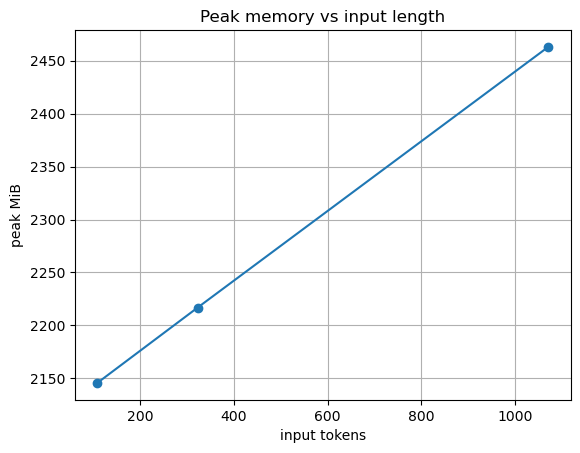

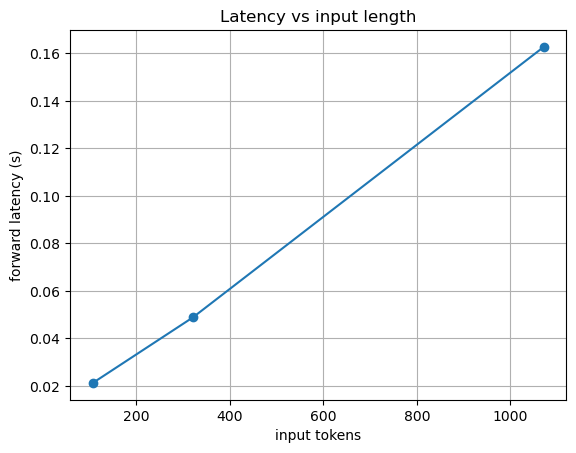

batch=1 | peak=2145.6 MiB
batch=2 | peak=2180.5 MiB
batch=4 | peak=2251.8 MiB


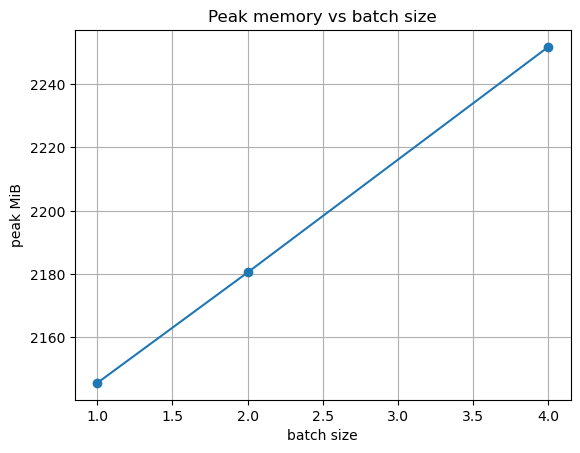

{'baseline': {'tokens': 108,
  'peak_mib': 2145.64013671875,
  'loss': 1.4202059507369995,
  'ppl': 4.137972571000584,
  'forward_latency_s': 0.021317296001749735},
 'context_sweep': {'lengths': [108, 322, 1071],
  'peak_mib': [2145.64306640625, 2216.71923828125, 2463.00634765625],
  'latency_s': [0.0212624739894333, 0.048879599334516875, 0.1626805056584999],
  'max_ctx': 2048,
  'targets_used': [64, 256, 1024]},
 'precision_compare': {'float16': {'peak_mib': 4245.2275390625,
   'ppl': 4.137972571000584},
  'float32': {'peak_mib': 4245.8193359375, 'ppl': 4.137972571000584}},
 'batch_sweep': {'batch_sizes': [1, 2, 4],
  'peak_mib': [2145.64306640625, 2180.53369140625, 2251.751953125],
  'target_len': 128}}

In [14]:
start()